In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [2]:
# reading the west Melbourne solar exposure dataset
df_solar= pd.read_csv('cleaned_BOM_data.csv', na_values='?')
print(df_solar.shape)
df_solar.head()

(256757, 6)


,Station Number,Daily Solar Radiation,Station Name,Latitude,Longitude,Date
0,86020,33.50,CHELTENHAM KINGSTON CENTRE,-37.96,145.08,1990-01-01
1,86020,30.90,CHELTENHAM KINGSTON CENTRE,-37.96,145.08,1990-01-02
2,86020,28.75,CHELTENHAM KINGSTON CENTRE,-37.96,145.08,1990-01-03
3,86020,26.60,CHELTENHAM KINGSTON CENTRE,-37.96,145.08,1990-01-04
4,86020,29.70,CHELTENHAM KINGSTON CENTRE,-37.96,145.08,1990-01-05


In [3]:
df_solar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256757 entries, 0 to 256756
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Station Number         256757 non-null  int64  
 1   Daily Solar Radiation  256757 non-null  float64
 2   Station Name           256757 non-null  object 
 3   Latitude               256757 non-null  float64
 4   Longitude              256757 non-null  float64
 5   Date                   256757 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 11.8+ MB


In [4]:
df_solar.shape

(256757, 6)

In [5]:
df_solar.isnull().sum()

Station Number           0
Daily Solar Radiation    0
Station Name             0
Latitude                 0
Longitude                0
Date                     0
dtype: int64

In [6]:
# replace the missing values from the previous value
df_solar.fillna(method='ffill', inplace=True)

In [7]:
# create a new date field
#df_solar["Date"] = df_solar['Year'].astype(str)+'-'+ df_solar['Month'].astype(str)+'-' + df_solar['Day'].astype(str)

In [8]:
df_solar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256757 entries, 0 to 256756
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Station Number         256757 non-null  int64  
 1   Daily Solar Radiation  256757 non-null  float64
 2   Station Name           256757 non-null  object 
 3   Latitude               256757 non-null  float64
 4   Longitude              256757 non-null  float64
 5   Date                   256757 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 11.8+ MB


In [9]:
df_solar['Date'] = pd.to_datetime(df_solar['Date'])

In [10]:
df_solar.head()

,Station Number,Daily Solar Radiation,Station Name,Latitude,Longitude,Date
0,86020,33.50,CHELTENHAM KINGSTON CENTRE,-37.96,145.08,1990-01-01
1,86020,30.90,CHELTENHAM KINGSTON CENTRE,-37.96,145.08,1990-01-02
2,86020,28.75,CHELTENHAM KINGSTON CENTRE,-37.96,145.08,1990-01-03
3,86020,26.60,CHELTENHAM KINGSTON CENTRE,-37.96,145.08,1990-01-04
4,86020,29.70,CHELTENHAM KINGSTON CENTRE,-37.96,145.08,1990-01-05


In [11]:
# create a new data frame with only the required fields

solar_exp = df_solar[["Date","Station Name","Daily Solar Radiation"]]

solar_exp.rename(columns={"Daily Solar Radiation":"Exposure", "Station Name":"Station"}, inplace=True)

# set the date as the index, without this the model does not work
solar_exp.set_index("Date", inplace=True)

# keep the station names
stations = solar_exp["Station"].unique()

# re sample the daily data to be monthly totals data. Since totals are more relevant for us
# https://stackoverflow.com/a/39186403
grouped = solar_exp.groupby('Station').resample('MS')['Exposure'].sum()

#solar_exp = solar_exp.resample('MS').sum()
solar_exp = grouped.unstack('Station', fill_value=0)
solar_exp.head()



stations

array(['CHELTENHAM KINGSTON CENTRE', 'MORNINGTON', 'PRAHRAN (COMO HOUSE)',
       'PRESTON RESERVOIR', 'YAN YEAN', 'TOOLANGI (MOUNT ST LEONARD DPI)',
       'ROSEBUD (COUNTRY CLUB)', 'DANDENONG', 'BASS', 'CRANBOURNE SOUTH',
       'MELBOURNE AIRPORT', 'KOO WEE RUP', 'MOUNT BURNETT',
       'DONCASTER (MANNINGHAM DEPOT)', 'COLDSTREAM', 'LAVERTON RAAF',
       'LITTLE RIVER (MOUNT ROTHWELL)', 'ROCKBANK (MELTON)',
       'TORQUAY GOLF CLUB', 'BULLENGAROOK SOUTH', 'OCEAN GROVE',
       'BREAKWATER (GEELONG RACECOURSE)'], dtype=object)

In [12]:
solar_exp.shape

(393, 22)

In [13]:
solar_exp.head()

Station,BASS,BREAKWATER (GEELONG RACECOURSE),BULLENGAROOK SOUTH,CHELTENHAM KINGSTON CENTRE,COLDSTREAM,CRANBOURNE SOUTH,DANDENONG,DONCASTER (MANNINGHAM DEPOT),KOO WEE RUP,LAVERTON RAAF,...,MORNINGTON,MOUNT BURNETT,OCEAN GROVE,PRAHRAN (COMO HOUSE),PRESTON RESERVOIR,ROCKBANK (MELTON),ROSEBUD (COUNTRY CLUB),TOOLANGI (MOUNT ST LEONARD DPI),TORQUAY GOLF CLUB,YAN YEAN
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-01,833.20,0.0,747.65,771.00,740.95,792.65,783.50,762.05,786.50,806.20,...,814.90,783.20,847.75,799.20,773.90,781.20,836.55,723.40,847.25,751.50
1990-02-01,623.40,0.0,535.65,593.55,585.45,595.85,589.35,570.25,587.00,612.30,...,610.35,592.35,622.65,577.25,551.50,602.15,635.15,566.50,611.35,561.40
1990-03-01,588.20,0.0,559.50,594.25,568.50,593.70,596.45,590.80,602.00,600.25,...,580.55,579.95,585.80,586.35,577.85,572.35,608.70,576.15,578.90,570.85
1990-04-01,281.50,0.0,291.90,288.15,274.65,275.05,279.90,272.25,272.05,307.25,...,285.75,285.40,312.75,274.70,275.15,297.95,300.85,250.00,307.50,293.15
1990-05-01,248.85,0.0,260.55,272.20,257.75,250.95,262.60,269.50,257.40,263.25,...,247.25,263.60,249.90,270.30,266.00,276.05,240.45,247.30,248.20,262.95


In [14]:
solar_exp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 393 entries, 1990-01-01 to 2022-09-01
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BASS                             393 non-null    float64
 1   BREAKWATER (GEELONG RACECOURSE)  393 non-null    float64
 2   BULLENGAROOK SOUTH               393 non-null    float64
 3   CHELTENHAM KINGSTON CENTRE       393 non-null    float64
 4   COLDSTREAM                       393 non-null    float64
 5   CRANBOURNE SOUTH                 393 non-null    float64
 6   DANDENONG                        393 non-null    float64
 7   DONCASTER (MANNINGHAM DEPOT)     393 non-null    float64
 8   KOO WEE RUP                      393 non-null    float64
 9   LAVERTON RAAF                    393 non-null    float64
 10  LITTLE RIVER (MOUNT ROTHWELL)    393 non-null    float64
 11  MELBOURNE AIRPORT                393 non-null    float64
 12  MOR

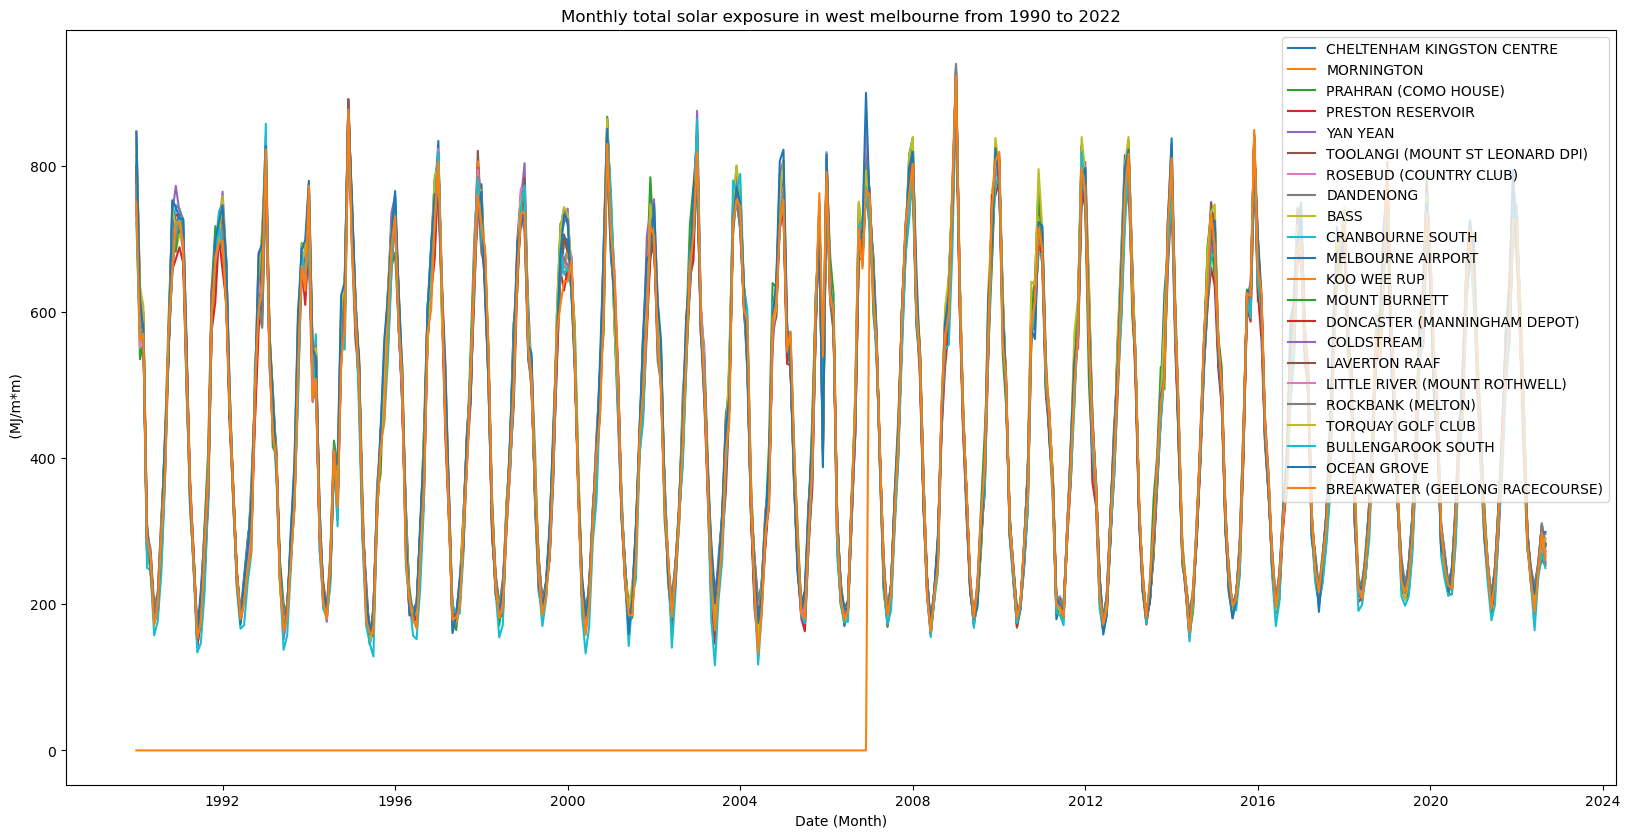

In [15]:
plt.figure(figsize=(20,10), dpi=100)
plt.plot(solar_exp.index, solar_exp)
plt.gca().set(title="Monthly total solar exposure in west melbourne from 1990 to 2022", xlabel='Date (Month)', ylabel=" (MJ/m*m)")
plt.legend(stations,loc="best")
plt.show()

In [16]:
# # Shift the current temperature to the next day. 
# predicted_df = solar_exp["Daily global solar exposure (MJ/m*m)"].to_frame().shift(1).rename(columns = {"Daily global solar exposure (MJ/m*m)": "T_mu_pred" })
# actual_df = solar_exp["Daily global solar exposure (MJ/m*m)"].to_frame().rename(columns = {"Daily global solar exposure (MJ/m*m)": "T_mu_actual" })

# # Concatenate the actual and predicted temperature
# one_step_df = pd.concat([actual_df,predicted_df],axis=1)

# # Select from the second row, because there is no prediction for today due to shifting.
# one_step_df = one_step_df[1:]
# one_step_df.head(10)

In [17]:
# #select data 
# import itertools

# # Define the p, d and q parameters to take any value between 0 and 2
# p = d = q = range(0, 2)

# # Generate all different combinations of p, d and q triplets
# pdq = list(itertools.product(p, d, q))

# # Generate all different combinations of seasonal p, d and q triplets
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# print('Examples of parameter combinations for Seasonal ARIMA...')
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [18]:
# import warnings
# import statsmodels.api as sm
# warnings.filterwarnings("ignore") # specify to ignore warning messages

# AIC = []
# SARIMAX_model = []


# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(solar_exp['Exposure'],
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)

#             results = mod.fit()

#             print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

#             AIC.append(results.aic)
#             SARIMAX_model.append([param, param_seasonal])
#         except:
#             continue

# print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

In [19]:
# Import the statsmodels library for using SARIMAX model
import statsmodels.api as sm

results ={}
for station in stations:
# Fit the SARIMAX model using optimal parameters from above
    mod = sm.tsa.statespace.SARIMAX(solar_exp[station],
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12), # 12 here since data is now monthly
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    result = mod.fit()
    results[station] =result

c:\Users\Melani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\Users\Melani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\Users\Melani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\Users\Melani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\Users\Melani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency in

In [20]:
results

{'CHELTENHAM KINGSTON CENTRE': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x252db734a30>,
 'MORNINGTON': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x252db74ae80>,
 'PRAHRAN (COMO HOUSE)': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x252db7bb130>,
 'PRESTON RESERVOIR': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x252db7a00d0>,
 'YAN YEAN': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x252db7f9100>,
 'TOOLANGI (MOUNT ST LEONARD DPI)': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x252db8100d0>,
 'ROSEBUD (COUNTRY CLUB)': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x252e2cfffa0>,
 'DANDENONG': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x252e2d1db50>,
 'BASS': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x252e54e8ca0>,
 'CRANBOURNE SOUTH': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x252e5506df0>,
 'MELBOURNE AIRPO

In [21]:

# use the model to predict values from 2017-Jan to 2023-Dec
pred = results["MORNINGTON"].get_prediction(start=pd.to_datetime('2017-01'),end=pd.to_datetime('2023-12'), dynamic=False)

pred_ci = pred.conf_int()



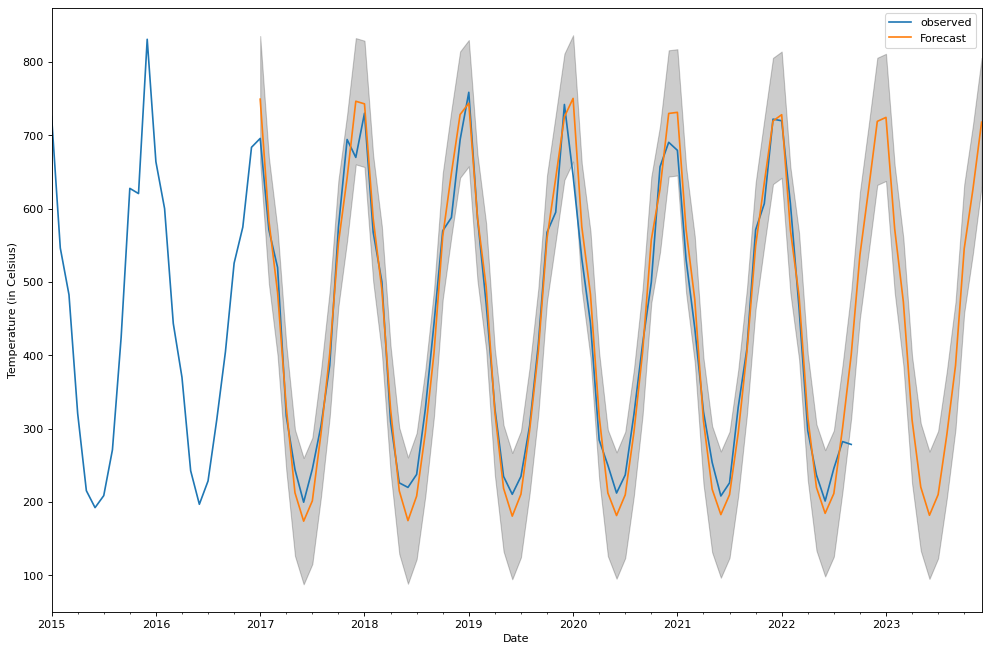

In [22]:

# Plot the predicted values with the real values so we can see how good the prediction is
from matplotlib.pyplot import figure

figure(figsize=(15, 10), dpi=80)

ax = solar_exp["MORNINGTON"]['2015':].plot(label='observed')
pred.predicted_mean.plot( label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')

#plt.ylim([-20,30])
plt.legend()
plt.show()

# the graph seems reasonably accurate

In [23]:
# How to predict for a specific month

predictions = {}

for station in stations:
    pred = results[station].get_forecast('2024-01')
    predictions[station] = pred.predicted_mean[-1:]

#print the last line of the result
#print(f'Date and predicted exposure: {predm.predicted_mean[-1:]}')

predictions

{'CHELTENHAM KINGSTON CENTRE': 2024-01-01    735.876003
 Freq: MS, Name: predicted_mean, dtype: float64,
 'MORNINGTON': 2024-01-01    723.431676
 Freq: MS, Name: predicted_mean, dtype: float64,
 'PRAHRAN (COMO HOUSE)': 2024-01-01    738.427682
 Freq: MS, Name: predicted_mean, dtype: float64,
 'PRESTON RESERVOIR': 2024-01-01    724.50689
 Freq: MS, Name: predicted_mean, dtype: float64,
 'YAN YEAN': 2024-01-01    715.215042
 Freq: MS, Name: predicted_mean, dtype: float64,
 'TOOLANGI (MOUNT ST LEONARD DPI)': 2024-01-01    701.378135
 Freq: MS, Name: predicted_mean, dtype: float64,
 'ROSEBUD (COUNTRY CLUB)': 2024-01-01    734.260028
 Freq: MS, Name: predicted_mean, dtype: float64,
 'DANDENONG': 2024-01-01    729.34846
 Freq: MS, Name: predicted_mean, dtype: float64,
 'BASS': 2024-01-01    722.16314
 Freq: MS, Name: predicted_mean, dtype: float64,
 'CRANBOURNE SOUTH': 2024-01-01    715.178134
 Freq: MS, Name: predicted_mean, dtype: float64,
 'MELBOURNE AIRPORT': 2024-01-01    713.626211
 Fr